# Riverstone NLP Test

 This test is designed to ascertain a candidate’s competency in Python to manipulate data, processes and  analyze text, and produce a simple R-Shiny application to explore results. Ability to communicate  through visualized output is important as well. Lastly, candidates must be able to explain the rationale for  processing and modeling decisions both through thorough documentation and discussion. 

In [10]:
# Title: RiverStone NLP Test
# Author: Tadhg Lynch
# Date: 2023-4-14

## Data 
Download the csv here https://www.kaggle.com/rootuser/worldnews-on-reddit 


In [11]:
# packages
import pandas as pd

#import data
df = pd.read_csv("data/reddit_worldnews_start_to_2016-11-22.csv")

# From kaggle:

# Reddit is a social network which divide topics into so called 'subreddits'.
# In subreddit 'worldnews', news of the whole world are published. The dataset contains following columns:
# time_created - a Unix timestamp of the submission creation date
# date_created - creation time in %Y-%m-%d
# up_votes - how often the submission was upvoted
# down_votes - how often the submission was downvoted
# title - the title of the submission
# over_18 - if the submission is for mature persons
# author - the reddit username of the author
# subreddit - this is always 'worldnews'

df.info() # non-nulls across the board, nice

# I like to see the data
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   subreddit     509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


## Request 1
Description: Build and graph a seasonal index of average upvotes by post at the Monthly, Day of Week, and Hour of  Day levels. 

In [84]:
# converting unix timestamp as will be needed for hourly
df['time_created'] = pd.to_datetime(df['time_created'], unit='s')

# check that new time_created matches date_created
matching = df['time_created'].dt.date == pd.to_datetime(df['date_created']).dt.date

# show df columns where matching is false
df[matching == False]


# There is a singular mismatched case that has been caused by a post being created at exactly midnight, so will be sticking with the converted unix timestamp
# despite not being shown, it has time of 00:00:00, so will be fine for hourly

# drop no longer needed date_created column
df = df.drop(['date_created'], axis=1)

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
343260,2015-02-10,2015-02-09,7,0,Christians in India want their own Christian c...,False,InternetOfficer,worldnews


In [ ]:
# Function to graph seasonal index
def graph_seasonal_index(df, level):
    # group by level
    df_grouped = df.groupby(level)['up_votes'].mean()

    # graph seasonal index
    df_grouped.plot()

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.month)

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.dayofweek)

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.hour)

## Request 2
Clean, scrub, and prepare post titles using standard NLP techniques. 

In [163]:
# The Subreddit posted rules:
# 1. No US Internal News or Politics
# 2. No Editorialized or Misleading Titles
# 3. No Feature stories
# 4. No Editorials, Opinion or Analysis Pieces
# 5. No Articles In Languages Other Than English
# 6. No Images, Videos or Audio Clips
# 7. No Bigotry or Other Offensive Content
# 8. No Personal Attacks On Other Users
# 9. No Memes, Gifs, unlabeled NSFW images
# 10. No Old News Articles (≥ 1 Week old)

# Main NLP Takeaways:
# no sentiment
# no other languages 
# unlikely to have poor grammar or misspellings (inferred by strict moderators)
# no emojis

# NLP ideas:
# Lots on Russia invasion of Ukraine, look out of more sparse references (e.g. Crimea, Moscow, Putin, etc.)... nevermind, dataset only goes up to 2016-11-22

In [151]:
# function to clean, scrub, and prepare post title using standard NLP techniques
def clean_post_title(post_title):
    # convert to lowercase
    post_title = post_title.lower()
    # remove numbers
    post_title = ''.join([i for i in post_title if not i.isdigit()])
    # remove single characters
    post_title = ' '.join([word for word in post_title.split() if len(word) > 1])
    # remove extra whitespace
    post_title = ' '.join(post_title.split())
    return post_title

clean_titles = df['title'].apply(clean_post_title)

# would apply more cleaning techniques, but OpenAI's models take care of this for us; in fact think what has been removed already may not be optimal as the model is designed to handle natural writing, so jumping to Request 3 and seeing how it goes before returning to this.

## Request 3
Cluster post titles and identify the top 20 clusters by frequency. Use of Chat-GPT AI is encouraged. 

In [2]:
import pandas as pd
import numpy as np
import requests
import csv

#### Using OpenAI's API: https://platform.openai.com/docs/introduction/overview
##### Model Options:
![Model Options](.\images\openai-model-options.png)

In [ ]:
# Ada costs $0.0004/1000 tokens, 1 token is roughly 4 characters, so let's work out how much this will end up costing
titles = df['title'].tolist()

# get total number of characters
total_chars = 0
for title in titles:
    total_chars += len(title)

total_tokens = total_chars / 4
total_cost = total_tokens * 0.0004 / 1000
print("total_titles", len(titles))
print("total_chars:", total_chars)
print("total_tokens:", total_tokens)
print("total_cost:", total_cost)

In [30]:
# Set your OpenAI API key
api_key = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

# Set the API endpoint and model name
endpoint = "https://api.openai.com/v1/embeddings"
model_name = "text-embedding-ada-002"

# Define your list of input strings
input_strings = titles

# Split input strings into batches
batch_size = 10000
input_string_batches = [input_strings[i:i+batch_size] for i in range(0, len(input_strings), batch_size)]

# Define the headers and data for the API request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Create a CSV file to write embeddings
with open("embeddings.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)

    # Write header to the CSV file
    writer.writerow(["Input_String", "Embedding"])

    # Loop through input string batches
    for batch in input_string_batches:
        data = {
            "input": batch,
            "model": model_name
        }

        # Send the API request
        response = requests.post(endpoint, headers=headers, json=data)

        # Parse the response and extract the embeddings
        if response.status_code == 200:
            embeddings = response.json()["data"]

            # Write embeddings to the CSV file
            for i in range(len(batch)):
                writer.writerow([batch[i], embeddings[i]])
        else:
            print("Failed to get embeddings. Response code:", response.status_code)


In [9]:
# load data
datafile_path = "./data/embeddings.csv"
df = pd.read_csv(datafile_path)

# extract embedding from string
df["Embedding"] = [i['embedding'] for i in df.Embedding.apply(eval)]

matrix = np.vstack(df.Embedding.values)
matrix.shape

# save matrix as this takes about 15 minutes to run
np.save("./data/embeddings.npy", matrix)

In [15]:
# checkpoint
# load data
matrix = np.load("./data/embeddings.npy")
matrix.shape

(509236, 1536)

In [17]:
matrix

array([[-1.2614552e-02,  2.4040286e-05,  2.0698800e-02, ...,
        -1.3577892e-02,  1.2066164e-03, -2.3536750e-02],
       [-1.5054497e-02, -2.1925455e-02, -1.5925085e-02, ...,
        -1.1443226e-03,  5.2034450e-03, -1.6273322e-03],
       [-2.1725131e-02, -1.1078199e-02,  1.2794850e-03, ...,
        -9.0835850e-03,  2.6064767e-02, -7.4595907e-03],
       ...,
       [-1.7998273e-02, -1.6423255e-03,  9.7731840e-03, ...,
        -3.3950370e-02,  4.7788983e-03, -9.0058670e-03],
       [-3.2808980e-02, -2.0751547e-02,  6.9127510e-03, ...,
        -7.7967860e-03,  6.1018323e-03, -3.6823694e-02],
       [-1.1200707e-02,  1.5606795e-02,  1.5515680e-02, ...,
         6.3650734e-03, -6.3976147e-03, -1.8873940e-03]])

In [18]:
# 1536 dimensions is a lot, so let's try to reduce this with LSA
from sklearn.decomposition import TruncatedSVD

sample = np.random.choice(matrix.shape[0], 10000, replace=False)

components_list = [i for i in range(1, 1537, 100)]
explained_variance_ratios = []
for components in components_list:
    svd = TruncatedSVD(n_components=components)
    svd.fit(matrix[sample])
    explained_variance_ratios.append(svd.explained_variance_ratio_.sum())

# plot explained variance ratio
import matplotlib.pyplot as plt
plt.plot(components_list, explained_variance_ratios)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

KeyboardInterrupt: 

In [17]:
# Deciding on number of clusters for k-means using mini-batch k-means
# Elbow method & silhouette score
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

sample = np.random.choice(matrix.shape[0], 50000, replace=False)
sum_of_squared_distances = []
silhouette_scores = []
K = range(10000, 50000, 10000)
for k in K:
    print(k)
    km = MiniBatchKMeans(n_clusters=k, n_init=1) #setting n_init to 1 to speed up
    km = km.fit(matrix[sample])
    sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(matrix[sample], km.labels_))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

10000
20000


KeyboardInterrupt: 

In [12]:
# running of full dataset with 1000 clusters
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

sample = np.random.choice(matrix.shape[0], 5000, replace=False)
km = MiniBatchKMeans(n_clusters=1000, n_init=1) #setting n_init to 1 to speed up
km = km.fit(matrix[sample])

Estimated number of clusters: 39
Estimated number of noise points: 24973
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.049s...
[t-SNE] Computed neighbors for 50000 samples in 47.423s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities 

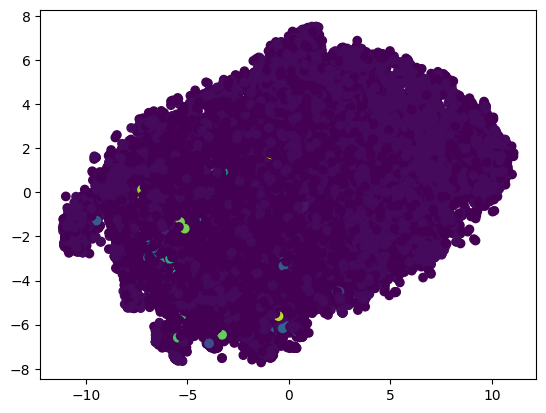

In [32]:
# trying it with DBSCAN
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

sample = np.random.choice(matrix.shape[0], 50000, replace=False)

db = DBSCAN(eps=0.5, min_samples=10).fit(matrix[sample]) # eps is the distance between points, min_samples is the minimum number of points in a cluster
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)  
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# visualise clusters using t-sne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(matrix[sample])

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels)
plt.show()

In [5]:
# now trying with agglomerative hierachical clustering using ward linkage
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

sample = np.random.choice(matrix.shape[0], 500, replace=False)
ac = linkage(matrix[sample], 'ward', optimal_ordering=True)

<bound method _AxesBase.set_ylabel of <Axes: >>

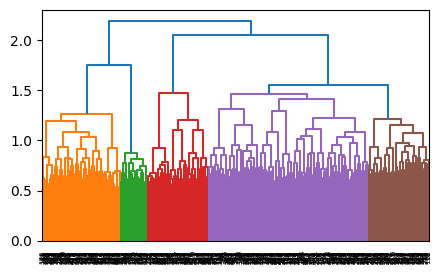

In [8]:
# visualise on dendrogram
fig, ax = plt.subplots(figsize=(5, 3)) # set size
dn = dendrogram(ac, ax=ax)
ax.set_ylabel

500
700
900
1100
1300
1500


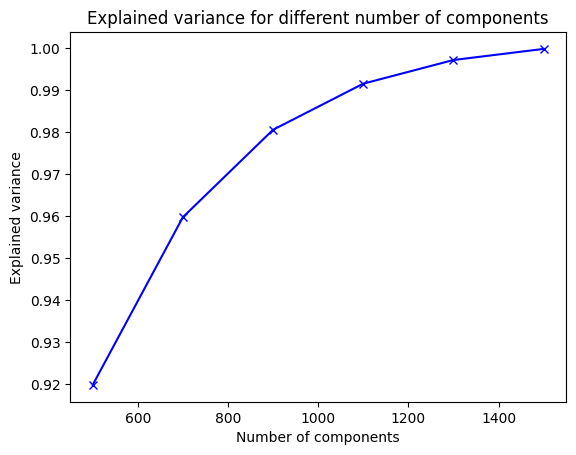

In [10]:
# reduce dimensionality using LSA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

sample = np.random.choice(matrix.shape[0], 5000, replace=False)

components_list = [i for i in range(500, 1501, 200)]
explained_variance = []
for components in components_list:
    print(components)
    svd = TruncatedSVD(n_components=components, random_state=42)
    svd.fit(matrix[sample])
    explained_variance.append(svd.explained_variance_ratio_.sum())
# plot
plt.plot(components_list, explained_variance, 'bx-')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance for different number of components')
plt.show()

(509236, 1536)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.348s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.152573
[t-SNE] KL divergence after 50 iterations with early exaggeration: 85.106926
[t-SNE] KL divergence after 300 iterations: 2.430278


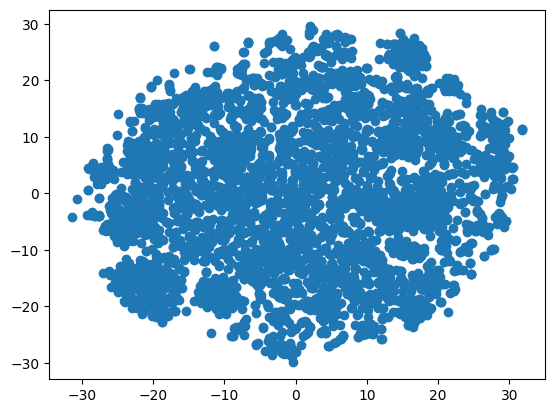

In [13]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

# 500 seems like plenty
svd = TruncatedSVD(n_components=500, random_state=42)
X_reduced = svd.fit_transform(matrix[sample])
X_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(X_reduced)

#plot tsne
plt.scatter(X_tsne[:,0], X_tsne[:,1])
plt.show()

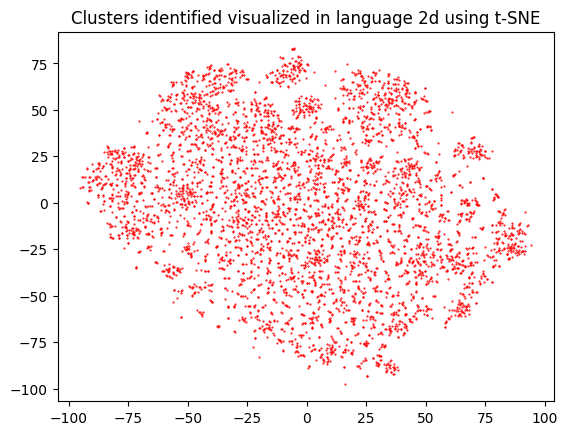

In [15]:


tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix[sample])

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

plt.scatter(x, y, marker=".", color="red", s=1)
plt.title("Clusters identified visualized in language 2d using t-SNE")
plt.show()

## Request 4
Build a simple, local web app displaying an interactive vizualization of the top 3 clusters from Request 3. 


In [ ]:
# building a simple, local web app using Shiny for python

# install.packages("shiny")
# install.packages("shinydashboard")
# install.packages("shinyWidgets")
# install.packages("shinyjs")
# install.packages("shinyalert")
# install.packages("shinythemes")
# install.packages("shinyFiles")
# install.packages("shinyBS")

library(shiny)
library(shinydashboard)
library(shinyWidgets)
library(shinyjs)

# design ui to show interactive visual of top three clusters from df['cluster'] and df['title']
ui <- dashboardPage(
    dashboardHeader(title = "Reddit Title Clustering"),
    dashboardSidebar(
        sidebarMenu(
            menuItem("Home", tabName = "home", icon = icon("home")),
            menuItem("About", tabName = "about", icon = icon("info"))
        )   
    ),
    dashboardBody(
        tabItems(
            tabItem(tabName = "home",
                    fluidRow(
                        column(12, h1("Reddit Title Clustering"))
                    ),
                    fluidRow(
                        column(12, h3("Select a cluster to see the top 10 titles"))
                    ),
                    fluidRow(
                        column(12, selectInput("cluster", "Cluster", choices = c("1", "2", "3")))
                    ),
                    fluidRow(
                        column(12, h3("Select a title to see the top 10 most similar titles"))
                    ),
                    fluidRow(
                        column(12, selectInput("title", "Title", choices = c("1", "2", "3")))
                    )
            ),
            tabItem(tabName = "about",
                    fluidRow(
                        column(12, h1("About"))
                    ),
                    fluidRow(
                        column(12, h3("This app was built using Shiny for R and Python. The data was scraped from Reddit using the Pushshift API. The titles were then embedded using OpenAI's text embedding model. The embeddings were then clustered using k-means. The app was built using Shiny for R and Python."))
                    )
        )
    )
)

# launch app
shinyApp(ui = ui, server = function(input, output) {})